In [4]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from FFNN import FFNN
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path 
root_path = Path.cwd().parent
fig_path = root_path / 'figs'
plt.rcParams.update({'text.usetex': True, 'font.size': 18, 'font.family': 'serif', 'font.serif': 'Computer Modern Sans Serif', 'font.weight': 100, 'mathtext.fontset': 'cm', 'xtick.labelsize': 16, 'ytick.labelsize': 16})

from activation_funcs import sigmoid, RELU, LRELU
from cost_funcs import CostLogReg, CostLogReg_derivative
from Schedulers import Adam, Constant, Momentum, RMS_prop, Adagrad, AdagradMomentum
from utils import gridsearch_plot

plt.style.use('seaborn-darkgrid')


C:\Users\Erik\AppData\Local\Temp\ipykernel_99836\1150476237.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [5]:
seed = 42069
np.random.seed(seed)

# Load breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target.reshape(-1, 1)  # Reshape to match FFNN output shape

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
seed = 42
np.random.seed(seed)

# Define network architecture
input_size = X.shape[1]  # 30 features
hidden_layers = [15]  
output_size = 1  # Binary classification
dimensions = (input_size, *hidden_layers, output_size)

# Create model
model = FFNN(
	layer_sizes=dimensions,
	hidden_funcs=[sigmoid],  # Sigmoid activation for hidden layers
	output_func=sigmoid,  # Sigmoid for output layer since binary classification
	cost_func=CostLogReg,  # Logistic regression cost function
	cost_der=CostLogReg_derivative,  # Derivative of logistic regression cost function
	seed=seed,
)

# Training parameters
scheduler = Adam(eta=0.001, rho=0.9, rho2=0.999)
epochs = 20
batches = 20
lambda_value = 0.01

# Train model
scores = model.fit(
	X_train_scaled, 
	y_train,
	scheduler=scheduler,
	epochs=epochs,
	batches=batches,
	lmbda=lambda_value,
	X_test=X_test_scaled,
	y_test=y_test
)

cost_train = scores["cost"][-1]
cost_test = scores["test_cost"][-1]

train_accuracy = scores["train_accuracy"][-1]
test_accuracy = scores["test_accuracy"][-1]

print(f"\nFinal Training Cost: {cost_train:.4f}")
print(f"Final Test Cost: {cost_test:.4f}")
print(f"\nFinal Training Accuracy: {train_accuracy:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Classification task detected
Adam: Eta=0.001, Lambda=0.01
  [=>--------------------------------------] 5.000% | training_scores: 11.4 | test_scores: 11.8 | train_acc: 0.670 | test_acc: 0.658 

  [=======================================>] 100.0% | training_scores: 1.44 | test_scores: 2.73 | train_acc: 0.958 | test_acc: 0.921 
Final Training Cost: 1.4423
Final Test Cost: 2.7268

Final Training Accuracy: 0.9582
Final Test Accuracy: 0.9211


# Hyperparameter space analysis

## Regularization vs learning rate

In [7]:
seed = 42
np.random.seed(seed)

# Define network architecture
input_size = X.shape[1]  # 30 features
hidden_layers = [15]  
output_size = 1  # Binary classification
dimensions = (input_size, *hidden_layers, output_size)

# Create model
model = FFNN(
	layer_sizes=dimensions,
	hidden_funcs=[sigmoid],  # Sigmoid activation for hidden layers
	output_func=sigmoid,  # Sigmoid for output layer since binary classification
	cost_func=CostLogReg,  # Logistic regression cost function
	cost_der=CostLogReg_derivative,  # Derivative of logistic regression cost function
	seed=seed,
)

# Training parameters
epochs = 20
batches = 20

lambda_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
eta_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

train_accuracy_1 = np.zeros([len(lambda_values), len(eta_values)])
test_accuracy_1 = np.zeros([len(lambda_values), len(eta_values)])


for i, lambda_value in enumerate(lambda_values):
	for j, eta_value in enumerate(eta_values):
		model.reset_weights()
		scheduler = Adam(eta=eta_value, rho=0.9, rho2=0.999)
		# Train model
		scores = model.fit(
			X_train_scaled, 
			y_train,
			scheduler=scheduler,
			epochs=epochs,
			batches=batches,
			lmbda=lambda_value,
			X_test=X_test_scaled,
			y_test=y_test
		)

		train_accuracy_1[i][j] = scores["train_accuracy"][-1]
		test_accuracy_1[i][j] = scores["test_accuracy"][-1]

Classification task detected
Adam: Eta=1e-05, Lambda=1e-05
  [=======================================>] 100.0% | training_scores: 17.8 | test_scores: 18.2 | train_acc: 0.486 | test_acc: 0.474 Adam: Eta=0.0001, Lambda=1e-05
  [=======================================>] 100.0% | training_scores: 13.8 | test_scores: 14.2 | train_acc: 0.600 | test_acc: 0.588 Adam: Eta=0.001, Lambda=1e-05
  [=======================================>] 100.0% | training_scores: 1.44 | test_scores: 2.73 | train_acc: 0.958 | test_acc: 0.921 Adam: Eta=0.01, Lambda=1e-05
  [=======================================>] 100.0% | training_scores: 0.228 | test_scores: 0.606 | train_acc: 0.993 | test_acc: 0.982 Adam: Eta=0.1, Lambda=1e-05
  [=======================================>] 100.0% | training_scores: 0.152 | test_scores: 1.51 | train_acc: 0.996 | test_acc: 0.956   Adam: Eta=1e-05, Lambda=0.0001
  [=======================================>] 100.0% | training_scores: 17.8 | test_scores: 18.2 | train_acc: 0.486 | test_

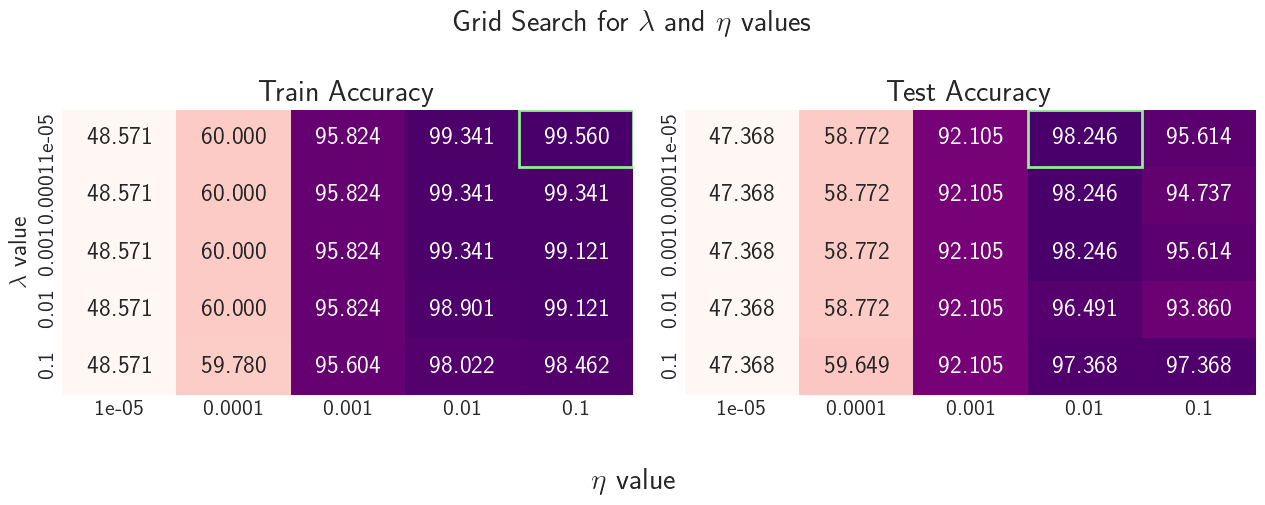

In [20]:
fig, axs = gridsearch_plot((train_accuracy_1, test_accuracy_1), (lambda_values, eta_values), "RdPu", ("max", "max"), opt_color="lightgreen", fmt1=".3%", fmt2=".3%")

fig.suptitle("Grid Search for $\lambda$ and $\eta$ values")
axs[0].set_title("Train Accuracy")
axs[1].set_title("Test Accuracy")
axs[0].set_ylabel(r"$\lambda$ value")
fig.supxlabel(r"$\eta$ value")
plt.tight_layout()

plt.show()

## Hidden layers vs neurons

In [30]:
seed = 42
np.random.seed(seed)

# Define network architecture
input_shape = X.shape[1]  # 30 features
hidden_nodes = [5, 10, 15, 20, 25]
hidden_layers = [1, 2, 3] 
output_shape = 1  # Binary classification

# Training parameters
epochs = 20
batches = 20

lambda_value = 1e-3
eta_value = 1e-3

train_accuracy_2 = np.zeros([len(hidden_layers), len(hidden_nodes)])
test_accuracy_2 = np.zeros([len(hidden_layers), len(hidden_nodes)])


for i, hidden_layer in enumerate(hidden_layers):
		for j, hidden_node in enumerate(hidden_nodes):
			hidden_shape = [hidden_node]*hidden_layer
			dims =  (input_shape, *hidden_shape, output_shape)

			model = FFNN(
						layer_sizes=dims,
						hidden_funcs=[sigmoid]*hidden_layer,
						output_func=sigmoid,
						cost_func=CostLogReg,
						seed=seed
					)

			scheduler = Adam(eta=eta_value, rho=0.9, rho2=0.999)
			# Train model
			scores = model.fit(
				X_train_scaled, 
				y_train,
				scheduler=scheduler,
				epochs=epochs,
				batches=batches,
				lmbda=lambda_value,
				X_test=X_test_scaled,
				y_test=y_test
			)

			train_accuracy_2[i][j] = scores["train_accuracy"][-1]
			test_accuracy_2[i][j] = scores["test_accuracy"][-1]

Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 2.05 | test_scores: 3.94 | train_acc: 0.941 | test_acc: 0.886 Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.835 | test_scores: 2.73 | train_acc: 0.976 | test_acc: 0.921 Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 1.44 | test_scores: 2.73 | train_acc: 0.958 | test_acc: 0.921 Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 1.21 | test_scores: 3.64 | train_acc: 0.965 | test_acc: 0.895 Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.987 | test_scores: 1.82 | train_acc: 0.971 | test_acc: 0.947 Classification task detected
Adam: Eta

## 

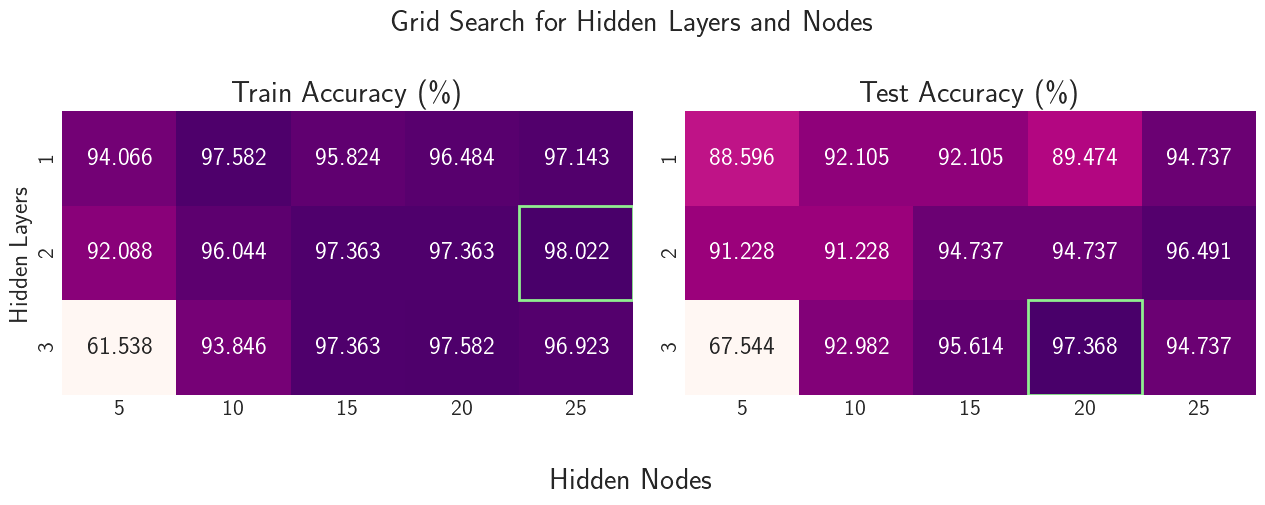

In [32]:
fig, axs = gridsearch_plot((train_accuracy_2, test_accuracy_2), (hidden_nodes, hidden_layers), "RdPu", ("max", "max"), opt_color="lightgreen", fmt1=".3%", fmt2=".3%")

fig.suptitle("Grid Search for Hidden Layers and Nodes")
axs[0].set_title("Train Accuracy (\%)")
axs[1].set_title("Test Accuracy (\%)")
axs[0].set_ylabel(r"Hidden Layers")
fig.supxlabel(r"Hidden Nodes")
plt.tight_layout()

plt.show()

#### Comments

- The high training accuracy and low validation accuracy suggest overfitting. This is likely due to the small dataset size. 

## Hidden layers vs Activation function

In [23]:
seed = 42
np.random.seed(seed)

# Define network architecture
input_shape = X.shape[1]  # 30 features
hidden_nodes = [15]
hidden_layers = [1, 2, 3]
activation_funcs = [sigmoid, RELU, LRELU]
activation_names = ["Sigmoid", "RELU", "Leaky RELU"]
output_shape = 1  # Binary classification

# Training parameters
epochs = 20
batches = 20

lambda_value = 1e-3
eta_value = 1e-3

train_accuracy_3 = np.zeros([len(hidden_layers), len(activation_funcs)])
test_accuracy_3 = np.zeros([len(hidden_layers), len(activation_funcs)])


for i, hidden_layer in enumerate(hidden_layers):
		for j, activation_func in enumerate(activation_funcs):
			hidden_shape = [hidden_node]*hidden_layer
			dims =  (input_shape, *hidden_shape, output_shape)

			model = FFNN(
						layer_sizes=dims,
						hidden_funcs=[activation_func]*hidden_layer,
						output_func=sigmoid,
						cost_func=CostLogReg,
						seed=seed
					)

			scheduler = Adam(eta=eta_value, rho=0.9, rho2=0.999)
			# Train model
			scores = model.fit(
				X_train_scaled, 
				y_train,
				scheduler=scheduler,
				epochs=epochs,
				batches=batches,
				lmbda=lambda_value,
				X_test=X_test_scaled,
				y_test=y_test
			)

			train_accuracy_3[i][j] = scores["train_accuracy"][-1]
			test_accuracy_3[i][j] = scores["test_accuracy"][-1]

Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.987 | test_scores: 1.82 | train_acc: 0.971 | test_acc: 0.947 Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 1.37 | test_scores: 2.73 | train_acc: 0.960 | test_acc: 0.921 Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 1.37 | test_scores: 2.73 | train_acc: 0.960 | test_acc: 0.921 Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.683 | test_scores: 1.21 | train_acc: 0.980 | test_acc: 0.965 Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.987 | test_scores: 2.73 | train_acc: 0.971 | test_acc: 0.921 Classification task detected
Adam: Et

C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


  [=======================================>] 100.0% | training_scores: 0.683 | test_scores: 3.33 | train_acc: 0.980 | test_acc: 0.904 

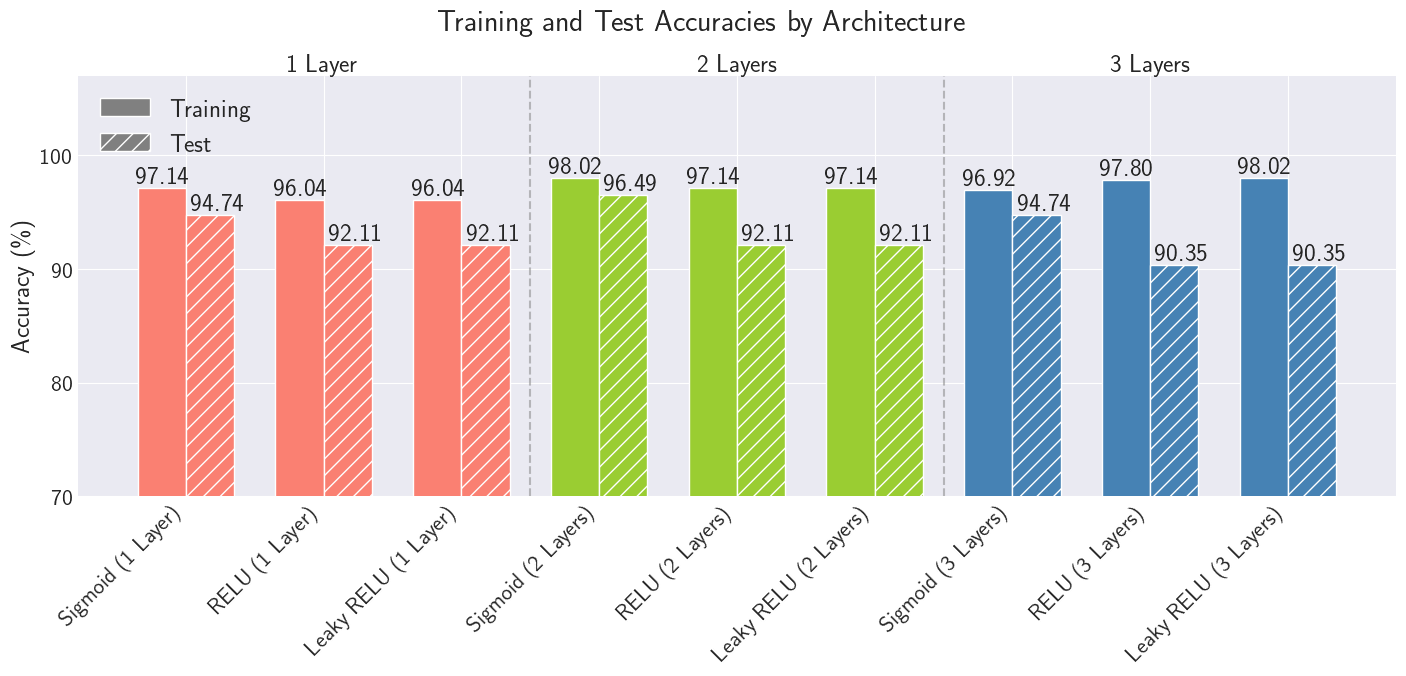

In [25]:

fig, ax = plt.subplots(figsize=(12*1.2, 6*1.2))

n_layers = train_accuracy_3.shape[0]
n_activations = train_accuracy_3.shape[1]

# Colors for each layer
layer_colors = {
	1: "salmon",
	2: "yellowgreen", 
	3: "steelblue"  
}

bar_width = 0.35
x = np.arange(n_layers * n_activations)

# Plot bars for each layer
for i in range(n_layers):
	for j in range(n_activations):
		idx = i * n_activations + j
		
		# Plot training accuracy
		ax.bar(x[idx] - bar_width/2, train_accuracy_3[i,j], bar_width, 
							color=layer_colors[i+1])
		# Add value annotation for training
		acc_val = train_accuracy_3[i,j]*100 
		ax.text(x[idx] - bar_width/2, train_accuracy_3[i,j], 
				f'{acc_val:.2f}%',
				ha='center', va='bottom')
		
		# Plot test accuracy with hatching
		ax.bar(x[idx] + bar_width/2, test_accuracy_3[i,j], bar_width,
							color=layer_colors[i+1], hatch='//')
		# Add value annotation for test
		test_val = test_accuracy_3[i,j]*100
		ax.text(x[idx] + bar_width/2 + .05, test_accuracy_3[i,j], 
				f'{test_val:.2f}%',
				ha='center', va='bottom')

# Customize plot
ax.set_xticks(x)
labels = [f"{act} ({i+1} Layer{'s' if i>0 else ''})" 
			for i in range(n_layers) 
			for act in activation_names]
ax.set_xticklabels(labels, rotation=45, ha='right')
plt.yticks(np.arange(0.7, 1.1, 0.1), [f"{i:.0%}" for i in np.arange(0.7, 1.1, 0.1)])
ax.set_ylabel('Accuracy (\%)')

ax.set_ylim(0.7, 1.07) 

# Add vertical lines between layers
for i in range(1, n_layers):
	ax.axvline(x=i*n_activations - 0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend
legend_elements = [
	plt.Rectangle((0,0),1,1, facecolor='gray', label='Training'),
	plt.Rectangle((0,0),1,1, facecolor='gray', hatch='//', label='Test')
]

ax.legend(handles=legend_elements, loc='upper left')

# Add layer annotations at the top
for i in range(n_layers):
	ax.text(i*n_activations + n_activations/2 - 0.5, ax.get_ylim()[1],
			f'{i+1} Layer{"s" if i>0 else ""}',
			ha='center', va='bottom')

plt.suptitle('Training and Test Accuracies by Architecture', y=0.95)
plt.tight_layout()
plt.show()


### Calculating all combinations of activation functions

In [14]:
def calculate_architectures(data, hidden_layers, activation_funcs, epochs, batches, scheduler, lambda_value):
    """
    Calculate training and test accuracies for neural networks with different architectures
    and activation function combinations.
    
    Parameters:
    -----------
    data : tuple
        Tuple containing (X_train, y_train, X_test, y_test)
    hidden_layers : list
        List of numbers of hidden layers to try
    activation_funcs : list
        List of activation functions to try
    epochs : int
        Number of training epochs
    batches : int
        Number of batches for training
    scheduler : object
        Learning rate scheduler (e.g., Adam)
    lambda_value : float
        Regularization parameter
        
    Returns:
    --------
    train_accuracies : list
        List of training accuracies for each architecture
    test_accuracies : list
        List of test accuracies for each architecture
    """
    X_train, y_train, X_test, y_test = data
    input_shape = X_train.shape[1]
    output_shape = 1  # Binary classification
    
    train_accuracies = []
    test_accuracies = []
    
    # For each number of hidden layers
    for n_layers in hidden_layers:
        # Generate all possible combinations of activation functions
        act_combinations = list(product(activation_funcs, repeat=n_layers))
        
        for act_combo in act_combinations:
            # Create layer dimensions
            dims = [input_shape] + [15]*n_layers + [output_shape]
            
            # Create model
            model = FFNN(
                layer_sizes=dims,
                hidden_funcs=list(act_combo),  # Convert tuple to list
                output_func=sigmoid,
                cost_func=CostLogReg,
                seed=42  # Fixed seed for reproducibility
            )
            
            # Train model
            scores = model.fit(
                X_train,
                y_train,
                scheduler=scheduler,
                epochs=epochs,
                batches=batches,
                lmbda=lambda_value,
                X_test=X_test,
                y_test=y_test
            )
            
            # Store final accuracies
            train_accuracies.append(scores["train_accuracy"][-1])
            test_accuracies.append(scores["test_accuracy"][-1])
            
    return np.array(train_accuracies), np.array(test_accuracies)

In [27]:
seed = 42
np.random.seed(seed)

data = (X_train_scaled, y_train, X_test_scaled, y_test)

# Define network architecture
input_shape = X.shape[1]  # 30 features
hidden_nodes = 15 
hidden_layers = [1, 2, 3] 
output_shape = 1  # Binary classification

activation_funcs = [sigmoid, RELU, LRELU]
activation_names = ['sigmoid', 'relu', 'leaky_relu']

# Training parameters
epochs = 20
batches = 20

lambda_value = 1e-3
eta_value = 1e-3

scheduler = Adam(eta=eta_value, rho=0.9, rho2=0.999)

train_accuracy_4, test_accuracy_4 = calculate_architectures(data, hidden_layers, activation_funcs, epochs, batches, scheduler, lambda_value)

Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 1.44 | test_scores: 2.73 | train_acc: 0.958 | test_acc: 0.921 Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 2.20 | test_scores: 2.73 | train_acc: 0.936 | test_acc: 0.921 Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 2.20 | test_scores: 2.73 | train_acc: 0.936 | test_acc: 0.921 Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.911 | test_scores: 1.82 | train_acc: 0.974 | test_acc: 0.947 Classification task detected
Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.759 | test_scores: 1.82 | train_acc: 0.978 | test_acc: 0.947 Classification task detected
Adam: Eta

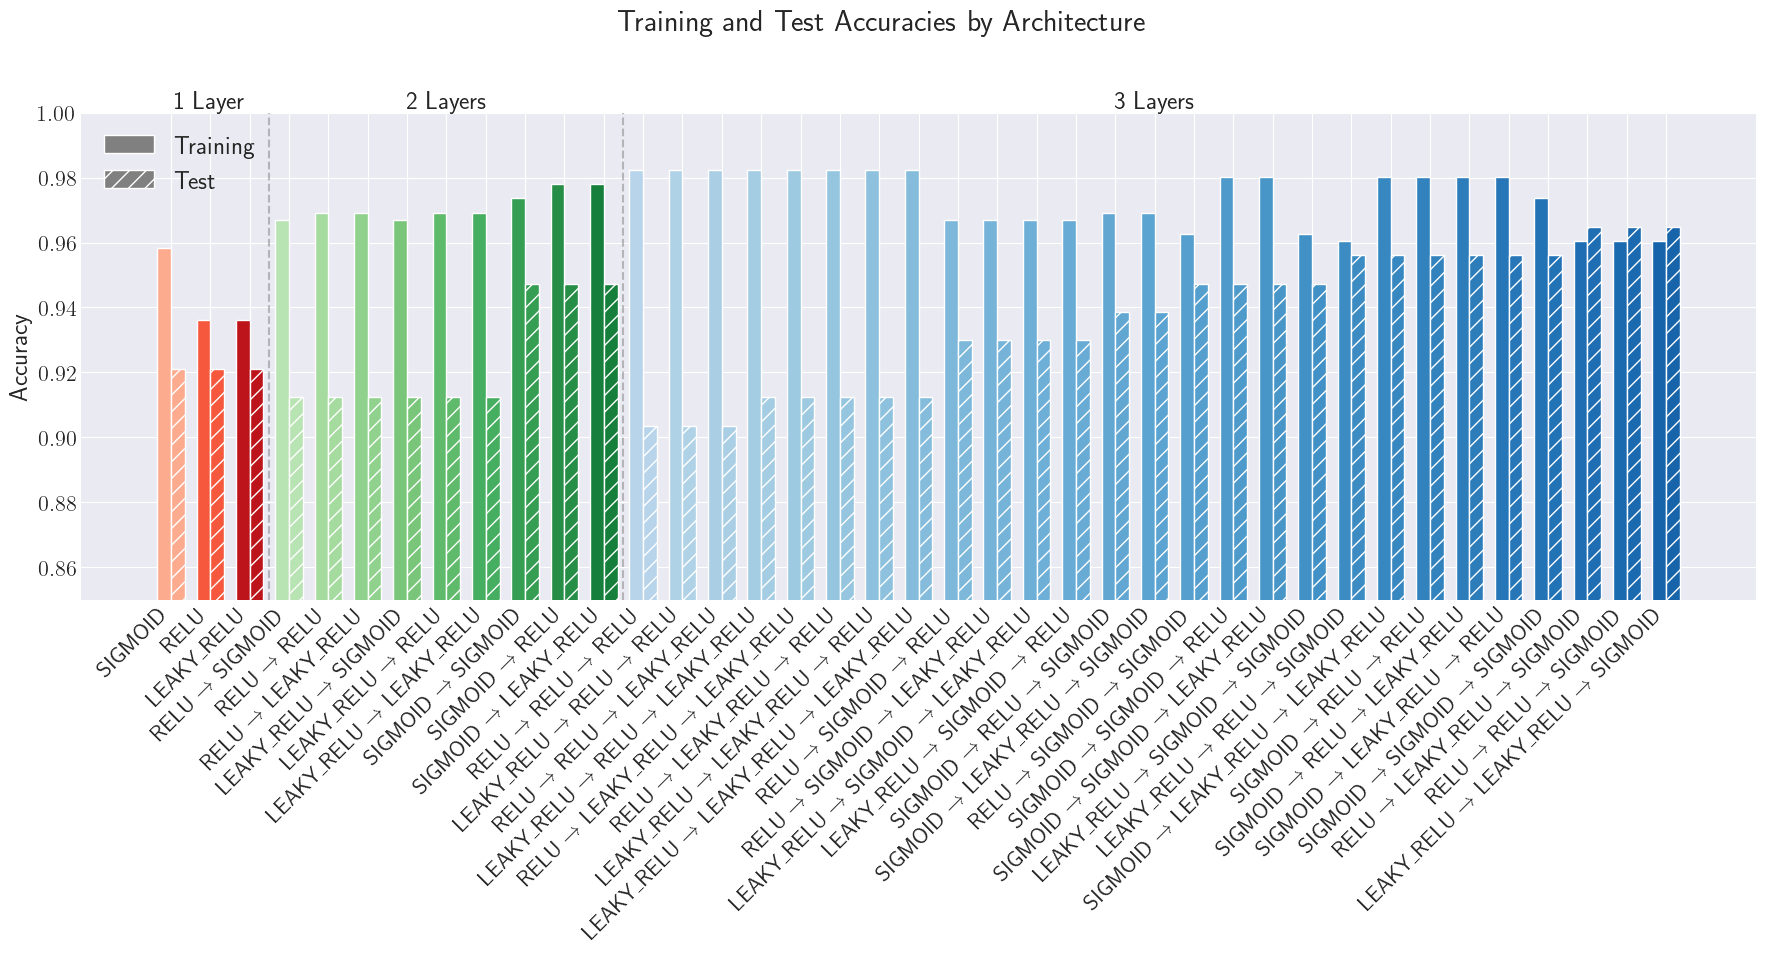

In [28]:

n_funcs = len(activation_names)
n_layers = int(np.log(len(train_accuracy_4)) / np.log(n_funcs))

# Generate activation function combinations
activation_combos = []
layer_indices = []  # Store layer number for each architecture

for i in range(n_layers):
	combinations = list(product(activation_names, repeat=i+1))
	for combo in combinations:
		activation_combos.append(' → '.join(act.upper() for act in combo))
		layer_indices.append(i+1)

# Create DataFrame for seaborn
data = []
for i, (train, test) in enumerate(zip(train_accuracy_4, test_accuracy_4)):
	layer_num = layer_indices[i]
	data.extend([
		{'Architecture': activation_combos[i], 'Accuracy': train, 'Type': 'Training',
			'Layer': f"{layer_num} Layer{'s' if layer_num>1 else ''}", 'LayerNum': layer_num},
		{'Architecture': activation_combos[i], 'Accuracy': test, 'Type': 'Test',
			'Layer': f"{layer_num} Layer{'s' if layer_num>1 else ''}", 'LayerNum': layer_num}
	])
df = pd.DataFrame(data)

# Create sorted indices for each layer (sorting by test accuracy)
sorted_combos = []  # To store sorted architecture combinations
color_indices = {}  # To store color indices for each architecture

# Define colormaps for each layer
layer_colormaps = {
	1: plt.cm.Reds,
	2: plt.cm.Greens,
	3: plt.cm.Blues
}

# Process each layer
cumsum = 0
for layer in range(1, n_layers + 1):
	# Get architectures for this layer and their test accuracies
	layer_data = df[(df['LayerNum'] == layer) & (df['Type'] == 'Test')]
	# Sort by test accuracy
	sorted_layer = layer_data.sort_values('Accuracy')
	# Store sorted architectures
	architectures = sorted_layer['Architecture'].tolist()
	sorted_combos.extend(architectures)
	
	# Calculate color indices for this layer
	n_arch = len(architectures)
	for idx, arch in enumerate(architectures):
		# Use range 0.3 to 0.8 to avoid too light or too dark colors
		color_indices[arch] = 0.3 + (0.5 * idx / (n_arch - 1 if n_arch > 1 else 1))
	
	cumsum += n_funcs**layer

fig, ax = plt.subplots(figsize=(15*1.2, 8*1.2))

bar_width = 0.35
x = np.arange(len(sorted_combos))

# Plot bars using sorted order
for i, arch in enumerate(sorted_combos):
	# Get layer number and color
	layer = df[df['Architecture'] == arch]['LayerNum'].iloc[0]
	color = layer_colormaps[layer](color_indices[arch])
	
	# Get accuracies
	train_val = df[(df['Architecture'] == arch) & (df['Type'] == 'Training')]['Accuracy'].iloc[0]
	test_val = df[(df['Architecture'] == arch) & (df['Type'] == 'Test')]['Accuracy'].iloc[0]
	
	# Plot bars
	ax.bar(x[i] - bar_width/2, train_val, bar_width, color=color)
	ax.bar(x[i] + bar_width/2, test_val, bar_width, color=color, hatch='//')

# Customize plot
ax.set_xticks(x)
ax.set_xticklabels(sorted_combos, rotation=45, ha='right')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.85, 1)

# Create custom legend
legend_elements = [
	plt.Rectangle((0,0),1,1, facecolor='gray', label='Training'),
	plt.Rectangle((0,0),1,1, facecolor='gray', hatch='//', label='Test'),
]
ax.legend(handles=legend_elements, loc='upper left')

# Add vertical lines separating different numbers of layers
cumsum = 0
for i in range(n_layers-1):
	cumsum += n_funcs**(i+1)
	ax.axvline(x=cumsum-0.5, color='gray', linestyle='--', alpha=0.5)

# Add text annotations for layer counts
cumsum = 0
for i in range(n_layers):
	n_combinations = n_funcs**(i+1)
	ax.text(cumsum + n_combinations/2 - 0.5, ax.get_ylim()[1],
			f'{i+1} Layer{"s" if i>0 else ""}',
			ha='center', va='bottom')
	cumsum += n_combinations

plt.suptitle('Training and Test Accuracies by Architecture', y=1.001)
plt.tight_layout()
plt.show()